## **Набор данных и переменные**

Набор данных и переменные
У нас есть данные о 90 189 игроках, которые установили игру во время выполнения AB-теста. Переменными являются:

1. userid - уникальный номер, который идентифицирует каждого игрока.
2. version - был ли игрок включен в контрольную группу (gate_30 - ворота на 30-м уровне) или в группу с перемещенными воротами (gate_40 - ворота на 40-м уровне).
3. sum_gamerounds - количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки.
4. retention_1 - вернулся ли игрок и сыграл ли он через 1 день после установки?
5. retention_7 - возвращался ли игрок к игре через 7 дней после установки?

Когда игрок устанавливал игру, ему случайным образом назначались либо gate_30, либо gate_40.

Итак, давайте загрузим ее и посмотрим!

In [1]:
from scipy import stats
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats import proportion
import numpy as np
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as ans
import pandas as pd
from statsmodels.stats.power import zt_ind_solve_power
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/My Drive/AB тесты GB/Файлы xlsx scv/cookie_cats 2.csv'

In [4]:
df =pd.read_csv(file_path)

In [5]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


## **Описательная статистика**

 попытаемся увидеть различия между группами A/B с точки зрения заданных переменных.

Сначала посмотрим, сколько у нас игроков.

In [6]:
# Кол-во уникальных игроков
df['userid'].nunique()

90189

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


Подсчет количества игроков в каждой группе A/B.

In [8]:
#Посмотрим количество участников в группах
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


Основное внимание в этом анализе будет уделено тому, как размещение ворот влияет на удержание игроков, но для развлечения построим распределение количества раундов игры, которые игроки сыграли в течение своей первой недели игры.

Text(0, 0.5, 'количество игроков')

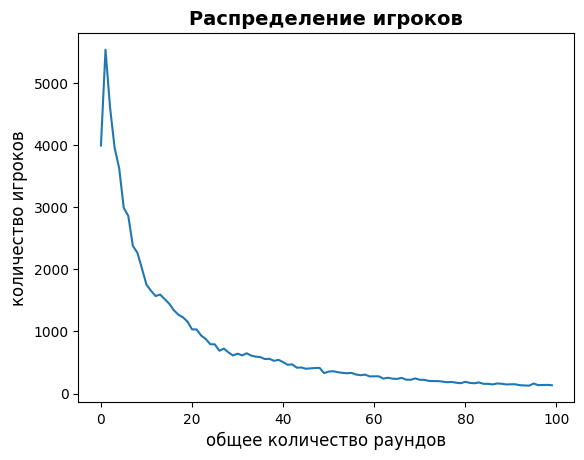

In [9]:
# Распределение игровых раундов

# # Подсчет количества игроков на каждое количество игровых раундов
plot_df = df.groupby("sum_gamerounds")["userid"].count()

# Построение графика распределения игроков, сыгравших от 0 до 100 раундов игры.
ax = plot_df.head(100).plot()
plt.title("Распределение игроков", fontweight="bold", size=14)
plt.xlabel("общее количество раундов", size=12)
plt.ylabel("количество игроков", size=12)


На графике выше мы видим, что некоторые игроки устанавливают игру, но потом никогда в нее не играют (0 раундов игры). Давайте выясним, сколько их всего.

In [10]:
df[df['sum_gamerounds'] == 0]['userid'].count()

3994

3994 игрока никогда не играли в эту игру, а только установили ее.

В индустрии видеоигр распространенным показателем того, насколько увлекательной является игра, является удержание игроков: процент игроков, которые возвращаются и играют в игру через 1-7 дней после ее установки. Чем выше показатель удержания, тем легче удержать игроков и создать большую базу игроков.

В качестве первого шага давайте рассмотрим, что такое 1-дневные и 7-дневные задержки в целом.

In [11]:
df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"коэффициент удержания за 1 день: {round(df_retention[0],2)}% \
      коэффициент удержания за 7-дней: {round(df_retention[1],2)}%")

коэффициент удержания за 1 день: 44.52%       коэффициент удержания за 7-дней: 18.61%


Итак, чуть меньше половины игроков возвращаются на следующий день после установки игры. 18% игроков возвращаются на 7-й день после установки игры.

Теперь, когда у нас есть контрольный показатель, давайте посмотрим, как различаются показатели удержания в двух группах A/B.

In [12]:
# Расчет 1-дневного и 7-дневного удержания для каждой группы A/B
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


Наблюдалось небольшое снижение продолжительности удержания в течение 1 дня, когда ворота были переведены на 40-й уровень (44,2%), по сравнению с контрольной группой, когда они были на 30-м уровне (44,8%).

Опять же, наблюдалось снижение 7-дневного удержания, когда ворота были перемещены на 40-й уровень (на 18,2%) по сравнению с контрольной группой, когда они были на 30-м уровне (на 19,8%).

Это небольшое изменение, но даже небольшие изменения в удержании могут оказать большое влияние. Но, хотя мы уверены в разнице в данных, насколько мы можем быть уверены в том, что врата 40-го уровня будут хуже в будущем?

Есть несколько способов, которыми мы можем добиться достоверности этих показателей удержания. Здесь мы будем использовать самонастройку.

**Для принятия решения воспользуемся Bootstrapp для более детального иследования.**

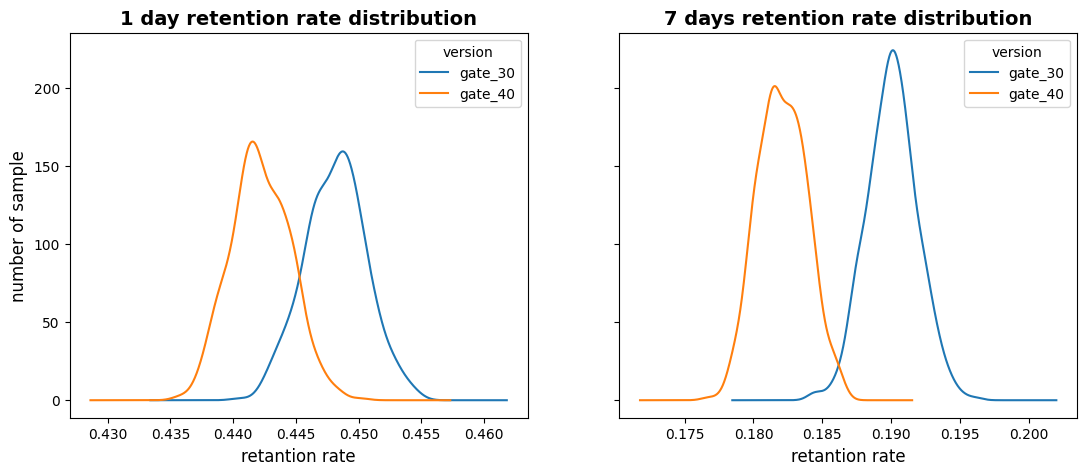

In [18]:
# Создание списка с загруженными средствами для каждой группы A/B
boot_1d = []
boot_7d = []
for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)

#  Преобразование списка во фрейм данных
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# График оценки плотности ядра для загрузочных дистрибутивов
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retantion rate",size=12)
ax1.set_ylabel("number of sample",size=12)
ax1.set_title("1 day retention rate distribution", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retantion rate",size=12)
ax2.set_title("7 days retention rate distribution", fontweight="bold",size=14)
plt.show()

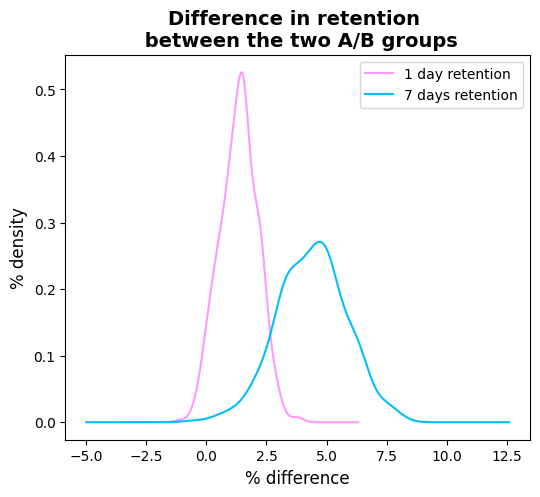

In [21]:
# Добавление столбца с разницей в процентах между двумя группами A/B
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

#  Построение графика разницы в процентах начальной загрузки
fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Difference in retention \n between the two A/B groups", fontweight="bold", size=14)
plt.legend()
plt.show()

In [23]:
# Вычисление вероятности того, что задержка на 1 день будет больше, когда ворота находятся на 30-м уровне.
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])

# Вычисление вероятности того, что 7-дневное удержание будет больше, если ворота находятся на 30-м уровне
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

# Довольно наглядно показывает вероятность
print(f"Вероятность удержания на 1 день выше, когда ворота находятся на уровне 30: {round(prob_1,2)*100}% \
      \nВероятность 7-дневного удержания выше, когда ворота находятся на 30-м уровне: {(prob_7)*100}% ")

Вероятность удержания на 1 день выше, когда ворота находятся на уровне 30: 96.0%       
Вероятность 7-дневного удержания выше, когда ворота находятся на 30-м уровне: 99.8% 


Вывод: если мы хотим сохранить высокий уровень удержания — как 1-дневного, так и 7-дневного — нам не следует перемещать ворота с 30-го на 40-й уровень.